In [1]:
import sys
sys.path.append('../')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models import *
from mrl.agent import *
from mrl.policy_gradient import PolicyGradient, TRPO, PPO
from mrl.environment import *

/home/dmai/miniconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [2]:
os.environ['DEFAULT_GPU'] = '1'
os.environ['ncpus'] = '32'

In [3]:
df = pd.read_csv('../../smiles_datasets/chembl/chembl.csv', usecols=['smiles', 'smiles_nc'])

In [4]:
df.head()

,smiles,smiles_nc
0,CN(C)[C@]1(c2ccccc2)CC[C@@H](NC(=O)NCCCc2ccccc...,CN(C)C1(c2ccccc2)CCC(NC(=O)NCCCc2ccccc2)CC1
1,CN[C@]1(c2ccccc2)CC[C@]2(CC1)OCCc1c3ccccc3[nH]c12,CNC1(c2ccccc2)CCC2(CC1)OCCc1c2[nH]c2ccccc12
2,O=C(OCCN1CCN(C(c2ccc(F)cc2)c2ccc(F)cc2)CC1)C12...,O=C(OCCN1CCN(C(c2ccc(F)cc2)c2ccc(F)cc2)CC1)C12...
3,CCn1c(N[C@H]2CC[C@H](O)CC2)nc2ccsc2c1=O,CCn1c(NC2CCC(O)CC2)nc2ccsc2c1=O
4,CCn1c(N[C@H]2CC[C@H](C(=O)O)CC2)nc2ccsc2c1=O,CCn1c(NC2CCC(C(=O)O)CC2)nc2ccsc2c1=O


In [5]:
df.shape

(2066376, 2)

In [6]:
df = df[df.smiles.map(lambda x: len(x)<=90)]

In [7]:
df.shape

(1910252, 2)

In [8]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

In [9]:
ds = TextDataset(df.smiles.values, vocab)

In [10]:
# d_vocab = len(vocab.itos)
# d_embedding = 256
# d_hidden = 1024
# n_layers = 3
# lstm_drop = 0.
# lin_drop = 0.
# bos_idx = vocab.stoi['bos']
# bidir = False
# tie_weights = True

# lm_model = LSTM_LM(d_vocab, d_embedding, d_hidden, n_layers,
#                 lstm_drop, lin_drop, bos_idx, bidir, tie_weights)

# loss = CrossEntropy()
# ds = TextDataset(df.smiles.values, vocab)

In [11]:
def vector_reconstruction_collate2(batch, pad_idx, batch_first=True):

    x,y = vector_reconstruction_collate(batch, pad_idx, batch_first)
    x = x[::-1]
    output = (x,y)
    return output

collate = partial(vector_reconstruction_collate2, pad_idx=vocab.stoi['pad'])
# ds = Vec_Recon_Dataset(['CCC'], vocab, ECFP6, collate_function=collate)
ds = Vec_Recon_Dataset(df.smiles.values, vocab, partial(failsafe_fp, fp_function=ECFP6), collate_function=collate)

d_vocab = len(vocab.itos)
d_embedding = 256
encoder_d_in = 2048
encoder_dims = [1024, 512]
encoder_drops = [0.1, 0.1]
d_hidden = 1024
n_layers = 3
d_latent = 512
dec_drop=0.0
condition_hidden=True
condition_output=True
prior=None
bos_idx=0

lm_model = MLP_VAE(d_vocab, d_embedding, encoder_d_in, encoder_dims, encoder_drops,
                d_hidden, n_layers, d_latent, dec_drop, condition_hidden, condition_output,
                prior, bos_idx)

class VAELoss():
    def __init__(self, weight=1.):
        self.ce = CrossEntropy()
        self.weight = weight
        
    def __call__(self, inputs, targs):
        output, kl_loss = inputs
        return self.ce(output, targs) + self.weight*kl_loss

loss = VAELoss(weight=0.1)

In [12]:
agent = GenerativeAgent(lm_model, vocab, loss, ds, base_model=None)

In [13]:
agent.train_supervised(500, 5, 1e-3)

Epoch,Train Loss,Valid Loss,Time
0,0.39922,0.47122,12:26
1,0.33127,0.42784,12:29
2,0.29410,0.38968,11:03
3,0.28380,0.38069,10:56
4,0.28094,0.37192,10:59


In [14]:
torch.save(agent.model.state_dict(), '../nbs/untracked_files/fp_vae_chembl.pt')

In [23]:
agent.model.load_state_dict(torch.load('../nbs/untracked_files/fp_vae_chembl.pt'))

<All keys matched successfully>

In [26]:
dl = agent.dataset.dataloader(128)

In [27]:
x,y = next(iter(dl))

In [28]:
x

(tensor([[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[ 0, 22, 26,  ...,  2,  2,  2],
         [ 0, 22, 26,  ...,  2,  2,  2],
         [ 0, 27, 19,  ...,  2,  2,  2],
         ...,
         [ 0, 22, 22,  ...,  2,  2,  2],
         [ 0, 22, 22,  ...,  2,  2,  2],
         [ 0, 27, 19,  ...,  2,  2,  2]]))

In [29]:
fp = x[0][0].unsqueeze(0).repeat(128,1)

In [31]:
fp = to_device(fp)

In [32]:
latent = agent.model.encoder(fp)

In [52]:
z,kl = agent.model.transition(latent, z_scale=0.)

In [53]:
kl

tensor(3.5766e-05, device='cuda:1', grad_fn=<MulBackward0>)

In [54]:
z

tensor([[-4.1041e-04, -5.9068e-04,  6.3178e-05,  ..., -6.5576e-04,
          3.4454e-05,  2.8731e-04],
        [-4.1041e-04, -5.9068e-04,  6.3178e-05,  ..., -6.5576e-04,
          3.4454e-05,  2.8731e-04],
        [-4.1041e-04, -5.9068e-04,  6.3178e-05,  ..., -6.5576e-04,
          3.4454e-05,  2.8731e-04],
        ...,
        [-4.1041e-04, -5.9068e-04,  6.3178e-05,  ..., -6.5576e-04,
          3.4454e-05,  2.8731e-04],
        [-4.1041e-04, -5.9068e-04,  6.3178e-05,  ..., -6.5576e-04,
          3.4454e-05,  2.8731e-04],
        [-4.1041e-04, -5.9068e-04,  6.3178e-05,  ..., -6.5576e-04,
          3.4454e-05,  2.8731e-04]], device='cuda:1', grad_fn=<AddBackward0>)

In [55]:
preds, _ = agent.model.sample_no_grad(z.shape[0], 90, z=z, temperature=0.1)

In [56]:
preds

tensor([[22, 22,  5,  ...,  2,  2,  2],
        [22, 22,  5,  ...,  2,  2,  2],
        [22, 22, 22,  ...,  2,  2,  2],
        ...,
        [22, 22,  5,  ...,  2,  2,  2],
        [22, 22,  5,  ...,  2,  2,  2],
        [22, 22,  5,  ...,  2,  2,  2]], device='cuda:1')

In [57]:
smiles = agent.reconstruct(preds)

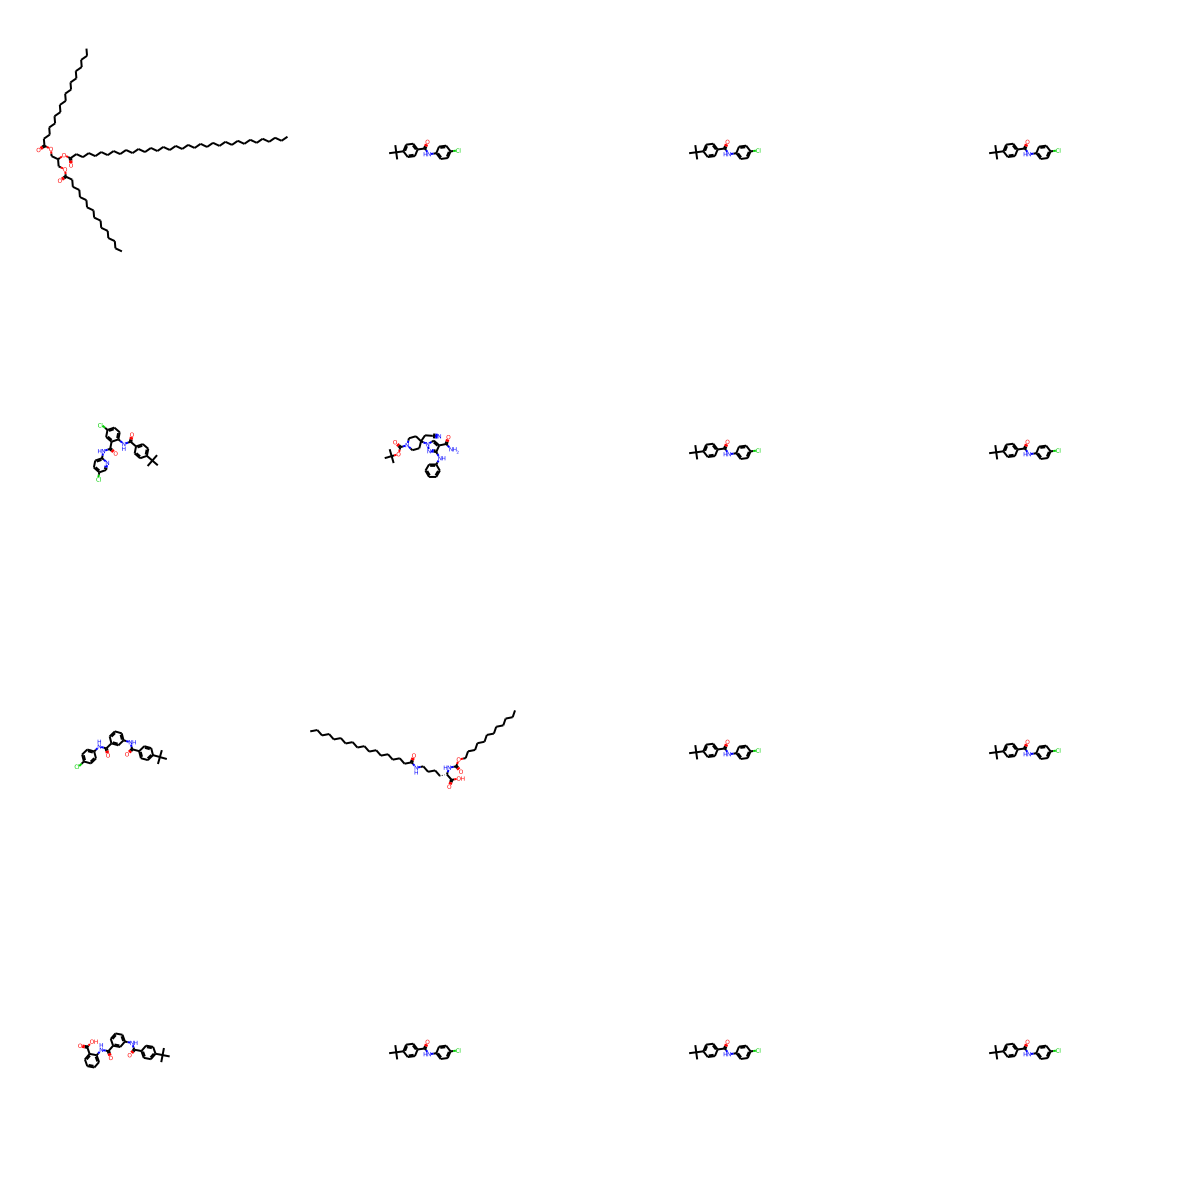

In [58]:
draw_mols(np.random.choice(to_mols(smiles),16), mols_per_row=4)

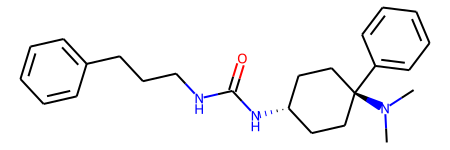

In [65]:
to_mol('CN(C)[C@]1(c2ccccc2)CC[C@@H](NC(=O)NCCCc2ccccc2)CC1')